In [1]:
import sys
import os
import time
import json
sys.path.append(".")
os.environ['JUPYTER_PATH'] = '.'
CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"

from globus_automate_client import create_action_client, create_flows_client, graphviz_format, state_colors_for_log
from ipywidgets import widgets
from IPython.display import display, display_svg, clear_output
import json
import time


## Important: A Note on Authentication and Authorization

* All interactions between users and services with the Globus Automate Platform are governed by use of Authentication and Authorization using the Globus Auth system. 
* In particular, this means that consent must be given by the user for each interaction taking place on their part, including in this Notebook.
* The first time you interact with each service such as the Flow service, and Action, or even a Flow instance, an additional browser window will open for you to Consent to proceeding..
* You may close the additional window after completing the Consent.

# Globus Automate: Flows and Actions

## Flow Definition

* Flows are composed of *Action* invocations
* Each Action invocation reads from and contributes back to the *Flow State* as referenced by the `ResultPath` properties of an Action.

In [2]:
flow_definition = {
  "Comment": "Two step transfer from Jupyter",
  "StartAt": "Transfer1",
  "States": {
    "Transfer1": {
      "Comment": "Initial Transfer from Campus to DTN in DMZ",
      "Type": "Action",
      "ActionUrl": "https://actions.globus.org/transfer/transfer",
      "Parameters": {
        "source_endpoint_id.$":"$.source_endpoint",
        "destination_endpoint_id.$": "$.intermediate_endpoint",
        "transfer_items": [{
          "source_path.$": "$.source_path",
          "destination_path.$": "$.intermediate_path",
          "recursive": True
        }]
      },
      "ResultPath": "$.Transfer1Result",
      "Next": "Transfer2"
    },
    "Transfer2": {
      "Comment": "Transfer from DMZ to dataset repository",
      "Type": "Action",
      "ActionUrl": "https://actions.globus.org/transfer/transfer",
      "Parameters": {
        "source_endpoint_id.$": "$.intermediate_endpoint",
        "destination_endpoint_id.$": "$.destination_endpoint",
        "transfer_items": [{
          "source_path.$": "$.intermediate_path",
          "destination_path.$": "$.destination_path",
          "recursive": True
        }]
      },
      "ResultPath": "$.Transfer2Result",
      "End": True
    }
  }
}

* This flow composes two transfers into a single logical operation
  * Suitable, for example, for doing a two stage transfer between a local campus endpoint, a DMZ data transfer endpoint, and a dataset repository.
  * Each step in the Flow uses the same Action: Transfer which is referenced by URL
  * Source and destination information for the Transfer state are given in `Parameters` and `ResultPath`
    * Format of the input is Action dependent (see below)
    
Next we _deploy_ the Flow so that we can execute below


In [3]:
flows_client = create_flows_client(CLIENT_ID)
flow = flows_client.deploy_flow(flow_definition, title="Two Step Transfer Flow")
flow_id = flow['id']
print(f'Newly created flow with id:\n{flow_id}')

Newly created flow with id:
880c286e-62b4-4016-beeb-5e6d06c57a1b


* The newly created flow has an id which we use for referencing it, such as running it later.

* We can also use the id to lookup the Flow in the Flows service and get a rough visualization of the Flow's contents.

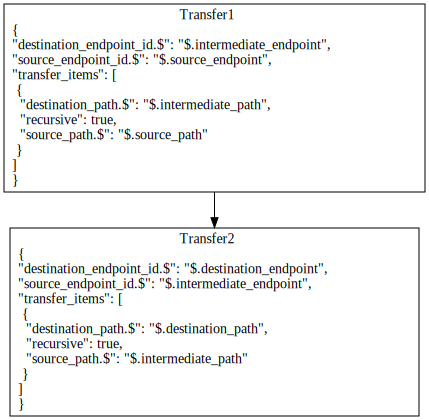

In [4]:
get_resp = flows_client.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

* The displayed output represents each Action state as a rectangle and provides the name of the state and the Parameters which will be used when it is run.
  * The Parameters reference the input shown below, and the required values are specific to the particular Action, Transfer, being run in the Action state.
  
* We prepare the Input and run the Flow below.
  * As defined here, the following need to be prepared using Globus Transfer:
    * On the endpoint 'go#ep1' a folder called `campus_source` containing a child folder called `dataset1`
      * A small data file may be placed in the `dataset1` folder to show data movement.
    * On the endpoint 'go#ep2' a folder called `campus_source`
    * On the endpoint 'go#ep1' a folder called `dataset_repository`
* We run the flow and monitor the Flow's execution
* Periodically, we poll to get the progress of the execution and represent the progress with a colored representation of the same flow visualization shown above.
  * Yellow or Orange represent states which are running or have not run yet
  * Green represents completed states
  * Upon completion, all details of the execution are displayed below the visualization.

Action f945d56d-024f-49de-a33f-5ad20fc3ee08 is in state SUCCEEDED at time Wed Jan  6 15:38:19 2021


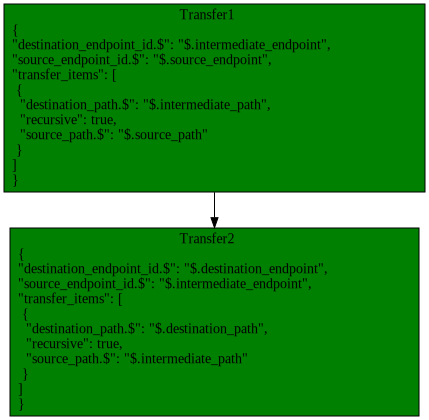

Final Result: {
  "output": {
    "Transfer1Result": {
      "action_id": "4tDJfjwnY3Tn",
      "completion_time": "2021-01-06T21:37:59.371532+00:00",
      "creator_id": "urn:globus:auth:identity:b44bddda-d274-11e5-978a-9f15789a8150",
      "details": {
        "bytes_checksummed": 0,
        "bytes_transferred": 208896,
        "canceled_by_admin": null,
        "canceled_by_admin_message": null,
        "command": "API 0.10",
        "completion_time": "2021-01-06T21:37:59+00:00",
        "deadline": "2021-01-07T21:37:58+00:00",
        "delete_destination_extra": false,
        "destination_endpoint": "go#ep2",
        "destination_endpoint_display_name": "Globus Tutorial Endpoint 2",
        "destination_endpoint_id": "ddb59af0-6d04-11e5-ba46-22000b92c6ec",
        "directories": 1,
        "effective_bytes_per_second": 146297,
        "encrypt_data": false,
        "event_list": [
          {
            "DATA_TYPE": "event",
            "code": "SUCCEEDED",
            "descript

In [5]:
flow_input = {
  "source_endpoint": "go#ep1",
  "source_path": "/~/campus_source/dataset1/",
  "intermediate_endpoint": "go#ep2",
  "intermediate_path": "/~/campus_source/dataset1/",
  "destination_endpoint": "go#ep1",
  "destination_path": "/~/dataset_repository/dataset1",
}

action_id = ''
run_resp = flows_client.run_flow(flow_id, None, flow_input)
action_id = run_resp.data['action_id']
print(f'action_id: {action_id}')
while(True):
    status_resp  = flows_client.flow_action_status(flow_id, None, action_id)
    log_resp = flows_client.flow_action_log(flow_id, None, action_id, limit=100)
    state_colors = state_colors_for_log(log_resp.data['entries'])
    run_graph = graphviz_format(flow_def, state_colors)
    print(f'Action {action_id} is in state {status_resp.data["status"]} at time {time.ctime()}')
    display(run_graph)
    if status_resp.data['status'] in ('SUCCEEDED', 'FAILED'):
        break
    print(f'Recent state details: {status_resp["details"]}')
    time.sleep(5)
    clear_output(wait=True)
print(f"Final Result: {json.dumps(status_resp['details'], indent=2)}")